In [1]:
from confluent_kafka import Consumer
from common.config import CONSUMER_KAFKA_CONF as KAFKA_CONF, TOPIC_NAME, TIMEZONE
from common.logger import configure_logger

logger = configure_logger(__name__)

consumer = Consumer(KAFKA_CONF)
consumer.subscribe([TOPIC_NAME])

In [2]:
import ast
from datetime import datetime
import pytz

utc_timezone = pytz.timezone('UTC')
jst_timezone = pytz.timezone(TIMEZONE)

def get_cpu():
    while True:
        msg = consumer.poll(0.01)
        if msg is None:
            continue

        utc_time = utc_timezone.localize(datetime.utcfromtimestamp(msg.timestamp()[1]/1000))
        jst_time = utc_time.astimezone(jst_timezone)

        yield jst_time, ast.literal_eval(msg.value().decode('utf-8'))

In [3]:
cpu_gen = get_cpu()
logger.info(next(cpu_gen))

2023-05-18 13:53:12,709 - INFO - (datetime.datetime(2023, 5, 18, 13, 31, 25, 613000, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>), [3.1, 3.1, 1.0, 3.1, 4.2, 3.1, 2.1, 0.0, 2.1, 0.0, 1.0, 6.2, 2.1, 2.1, 0.0, 0.0])


In [6]:
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from collections import deque

app = JupyterDash(__name__)

app.layout = html.Div(
    [
        dcc.Graph(id='live-graph', animate=True),
        dcc.Interval(
            id='graph-update',
            interval=1 * 1000,
        ),
    ]
)

cpu_gen = get_cpu()
usages = next(cpu_gen)
logger.info(usages)

X = deque(maxlen=15)
Ys = [deque(maxlen=15) for _ in range(len(usages[1]))]


@app.callback(Output('live-graph', 'figure'),
              [Input('graph-update', 'n_intervals')])
def update_graph_scatter(input_data):
    x, y = next(cpu_gen)
    X.append(x)

    data = []
    for i, cpu_usage in enumerate(y):
        Ys[i].append(cpu_usage)
        data.append(go.Scatter(
            x=list(X),
            y=list(Ys[i]),
            name=f'CPU-{i}',
            mode='lines+markers'
        ))

    return {
        'data': data,
        'layout': go.Layout(
            xaxis=dict(range=[min(X), max(X)], title='Time'),
            yaxis=dict(range=[0, 100], title="CPU"),
        )
    }


app.run_server(mode='inline')



## CPU Usage Event Stream: 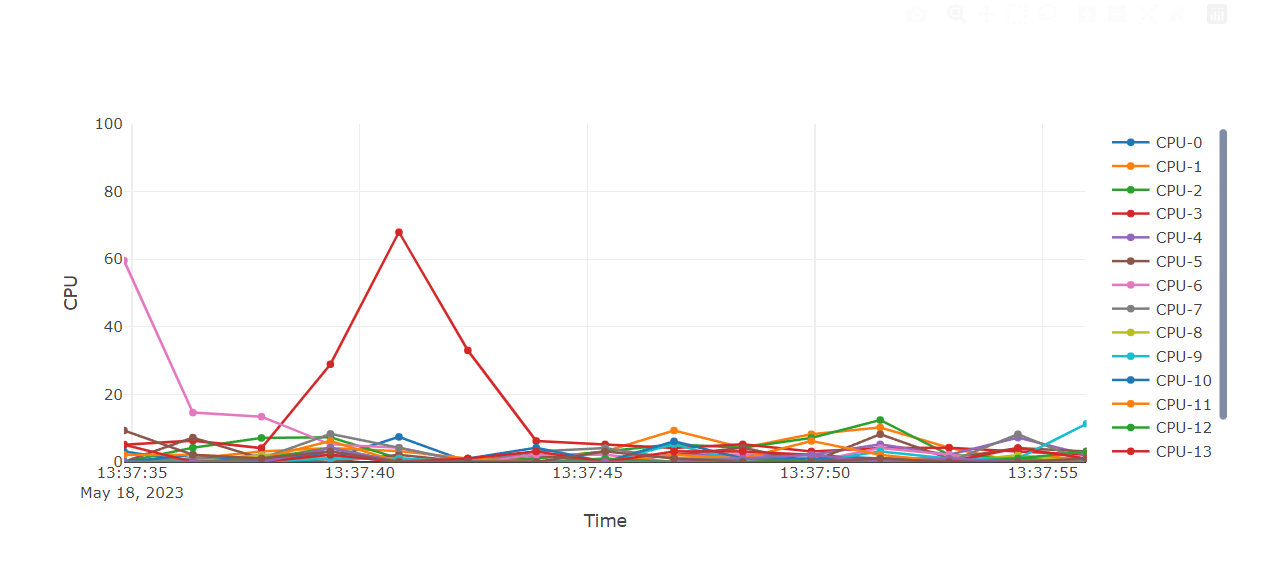